In [118]:
%matplotlib inline

In [103]:
import calour as ca
from calour.training import plot_roc
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, auc
from emperor import Emperor, nbinstall
from matplotlib.backends.backend_pdf import PdfPages

# old data table 

In [3]:
ldlr = ca.read_amplicon('data/microbiome/ldlr-deblur-refererence-hit-2k-wtax.biom', 
                        'data/combined_sample_metadata_HFD.txt', min_reads=100, normalize=100)

2018-12-29 16:37:50 WARNING These have metadata but do not have data - dropped (460): {'11548.A23.117.3', '11548.A20.107.12', '11548.A21.109.19', '11548.A21.111.15', '11548.A19.103.11', '11548.A23.119.10', '11548.A22.113.10', '11548.A22.116.4', '11548.A21.112.3', '11548.A20.105.4', '11548.A21.110.10', '11548.A23.120.14', '11548.A20.108.15', '11548.A21.111.8', '11548.A23.119.12', '11548.A23.119.11', '11548.A18.100.1', '11548.A21.112.7', '11548.A18.99.8', '11548.A21.109.17', '11548.A22.113.14', '11548.A21.109.2', '11548.A22.115.13', '11548.A18.98.16', '11548.A19.102.6', '11548.A23.120.3', '11548.A22.115.10', '11548.A23.117.20', '11548.A19.103.10', '11548.A22.116.14', '11548.A18.100.5', '11548.A20.108.9', '11548.A20.108.8', '11548.A23.119.5', '11548.A22.116.8', '11548.A19.104.8', '11548.A18.99.20', '11548.A20.107.2', '11548.A23.118.16', '11548.A20.108.20', '11548.A19.102.2', '11548.A22.114.13', '11548.A18.100.20', '11548.A18.97.16', '11548.A23.120.4', '11548.A18.98.18', '11548.A18.100.13'

In [4]:
apoe = ca.read_amplicon('data/microbiome/apoe-deblur-reference-hit-2k-wtax.biom',
                        'data/combined_sample_metadata_HFD.txt', min_reads=100, normalize=100)
apoe = apoe.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

2018-12-29 16:37:55 WARNING These have metadata but do not have data - dropped (182): {'10422.26.F.4', '10422.24.F.8', '10422.23.F.6', '10422.25.F.6', '10422.20.F.6', '10422.17.F.7', '10422.26.F.12', '10422.28.F.5', '10422.19.F.9', '10422.28.F.7', '10422.27.F.8', '10422.31.F.10', '10422.28.F.1', '10422.25.F.10', '10422.24.F.10', '10422.20.F.4', '10422.17.F.5', '10422.23.F.4', '10422.23.F.5', '10422.30.F.5', '10422.31.F.13', '10422.19.F.4', '10422.31.F.8', '10422.28.F.6', '10422.26.F.5', '10422.26.F.11', '10422.25.F.9', '10422.27.F.6', '10422.32.F.6', '10422.18.F.5', '10422.32.F.4', '10422.20.F.13', '10422.26.F.13', '10422.25.F.11', '10422.29.F.13', '10422.19.F.3', '10422.24.F.13', '10422.20.F.8', '10422.26.F.7', '10422.20.F.10', '10422.28.F.12', '10422.27.F.12', '10422.20.F.1', '10422.21.F.10', '10422.21.F.7', '10422.24.F.2', '10422.27.F.13', '10422.19.F.10', '10422.18.F.6', '10422.27.F.7', '10422.25.F.8', '10422.21.F.11', '10422.18.F.12', '10422.22.F.11', '10422.23.F.10', '10422.30.F.

In [5]:
exp = apoe.join_experiments(ldlr)

In [6]:
exp

AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 642 samples, 8648 features

# new data table

In [66]:
exp = ca.read_amplicon('combined_apoe_ldlr_norare_2k_matched.qza',
                       sample_metadata_file='data/combined_sample_metadata_HFD.txt', 
                       feature_metadata_file='taxonomy.tsv',
                       data_file_type='qiime2', min_reads=100, normalize=100)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [67]:
exp

AmpliconExperiment ("combined_apoe_ldlr_norare_2k_matched.qza") with 642 samples, 2791 features

In [68]:
exp.feature_metadata.rename({'Taxon': 'taxonomy'}, inplace=True, axis=1)

In [69]:
exp.feature_metadata.head()

,taxonomy,Confidence,_feature_id
Feature ID,,,
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,1.000000,AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCG...
AACGAGGGGGGCTAGCGTTATTCATCTTGACTGGGCGTAAAAGGTTCGTAGATGGTAAAGTAAGTTTCTTGCTAAAAATTAAAGCCTAACTTTTAAAAGTTTGTAAATACTGCTTTACTTGAGTTTAATACGGGAGGGTATAATTTTATT,k__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.989479,AACGAGGGGGGCTAGCGTTATTCATCTTGACTGGGCGTAAAAGGTT...
AACGTAGGAGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGCGCGTGCAGGCGGTAAGCTAAGTTGGGTGTGAAAGCTCCTGGCTCAACTGGGAGAGGTCGCTCAAGACTGGCTAACTCGAGGATGGTAGGGGAAGGTGGAATTCCGGG,k__Bacteria; p__Chloroflexi; c__Anaerolineae; ...,1.000000,AACGTAGGAGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGCGCG...
AACGTAGGGGGCAAGCGTTATCCGGATTCATTGGGCGTAAAGCACGCGCAGGCGGGCCGCTAAGCGGGACCTCTAATCTTGGGGCTCAACCTCAAGCCGGGTCCCGAACTGGCAGCCTCGAGTGCGGTAGGGGTAAGCGGAATTCCCGGT,k__Bacteria; p__Actinobacteria; c__Coriobacter...,0.999882,AACGTAGGGGGCAAGCGTTATCCGGATTCATTGGGCGTAAAGCACG...
AACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTCCTTTAAGTCTGATGTGAAATTCCGCGGCTCAACCGCGGGTGTGCATTGGAAACTGGGGGACTTGAGTGCGGAAGAGGGGAGCGGAATTCCCGG,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...,0.999786,AACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGCGCG...


# APOE and LDLR models

In [81]:
exp2 = exp.filter_prevalence(field='genotype', cutoff=0.000001, fraction=0.001)#.filter_samples('age', [10, 10.5], negate=True)
exp2

AmpliconExperiment ("combined_apoe_ldlr_norare_2k_matched.qza") with 642 samples, 2791 features

In [82]:
exp2_apoe = exp2.filter_samples('genotype', 'ApoE KO')
exp2_apoe

AmpliconExperiment ("combined_apoe_ldlr_norare_2k_matched.qza") with 460 samples, 2791 features

In [83]:
exp2_apoe.sample_metadata.exposure_type.value_counts()

Air    235
IHH    225
Name: exposure_type, dtype: int64

In [84]:
exp2_ldlr = exp2.filter_samples('genotype', 'LDLR KO')
exp2_ldlr.sample_metadata.exposure_type.value_counts()

IHH    92
Air    90
Name: exposure_type, dtype: int64

In [88]:
points = exp2_apoe.sample_metadata.age.unique()
points_accuracy = []
for i in np.sort(points):
    exp_ = exp2_apoe.filter_samples('age', i)
    it_apoe = exp_.classify('exposure_type',
                            RandomForestClassifier(n_estimators=500, random_state=9),
                            GroupKFold(5).split(exp_.data, exp_.sample_metadata['exposure_type'], exp_.sample_metadata['mouse_number']))
    res_apoe = next(it_apoe)
    s = roc_auc_score(res_apoe['Y_TRUE']=='IHH', res_apoe['IHH'])
    points_accuracy.append([i, s, exp_.shape[0]])

points_df = pd.DataFrame(points_accuracy, columns=['age', 'AUC', 'sample_size'])
points_df

,age,AUC,sample_size
0,10.0,0.875000,24
1,10.5,0.909722,24
2,11.0,1.000000,24
3,11.5,1.000000,23
4,12.0,1.000000,24
5,12.5,1.000000,23
6,13.0,1.000000,22
7,13.5,1.000000,22
8,14.0,1.000000,24
9,14.5,1.000000,24


In [105]:
points = exp2_ldlr.sample_metadata.age.unique()
points_accuracy = []
res_ = []
for i in np.sort(points):
    exp_ = exp2_ldlr.filter_samples('age', i)
    if exp_.shape[0] < 10: continue
    it = exp_.classify('exposure_type',
                        RandomForestClassifier(n_estimators=500, random_state=9),
                        GroupKFold(5).split(exp_.data, exp_.sample_metadata['exposure_type'], exp_.sample_metadata['mouse_number']))
    res = next(it)
    res['age'] = i
    res_.append(res)
    s = roc_auc_score(res['Y_TRUE']=='IHH', res['IHH'])
    points_accuracy.append([i, s, exp_.shape[0]])
res_df = pd.concat(res_, axis=0)
points_df = pd.DataFrame(points_accuracy, columns=['age', 'AUC', 'sample_size'])
points_df

,age,AUC,sample_size
0,11.0,0.714286,15
1,11.5,0.964286,15
2,12.0,0.781250,16
3,12.5,0.828125,16
4,13.0,0.875000,15
5,13.5,0.890625,16
6,14.0,1.000000,16
7,14.5,0.992188,16
8,15.0,1.000000,15
9,15.5,1.000000,15


In [123]:
it_apoe = exp2_apoe.classify('exposure_type',
                             RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                             exp2_apoe.data, exp2_apoe.sample_metadata['exposure_type'], exp2_apoe.sample_metadata['mouse_number']))

In [124]:
res_apoe = next(it_apoe)

In [125]:
res_apoe.head()

,Air,IHH,Y_TRUE,SAMPLE,CV
0,0.208,0.792,IHH,11548.A19.104.3,0
1,0.964,0.036,Air,11548.A21.112.11,0
2,0.924,0.076,Air,11548.A21.112.8,0
3,0.934,0.066,Air,11548.A22.113.17,0
4,0.060,0.940,IHH,11548.A20.105.17,0


In [126]:
from calour import training

In [127]:
%load_ext autoreload
%autoreload 2

In [128]:
from importlib import reload

In [129]:
reload(training)

<module 'calour.training' from '/opt/miniconda3/envs/qiime2-2018.11/lib/python3.5/site-packages/calour/training.py'>

2019-01-03 14:45:37 WARNING The cross validation fold 4 is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples in this cross validation for the class 'IHH'


/opt/miniconda3/envs/qiime2-2018.11/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd9f16aaf28>,
 0.99494949494949503)

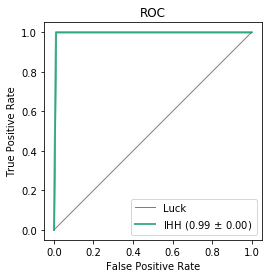

In [135]:
training.plot_roc(res_apoe, classes=['IHH'], cv=True)

In [24]:
clf_apoe = RandomForestClassifier(500, oob_score=True)
clf_apoe.fit(exp2_apoe.data, exp2_apoe.sample_metadata.exposure_type)
clf_apoe.oob_score_

1.0

In [138]:
res_apoe2ldlr = pd.DataFrame(clf_apoe.predict_proba(exp2_ldlr.data))
res_apoe2ldlr.columns = clf_apoe.classes_
res_apoe2ldlr['Y_TRUE'] = exp2_ldlr.sample_metadata['exposure_type'].values
res_apoe2ldlr['CV'] = 0

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd9f160dc88>,
 0.89811503828140782)

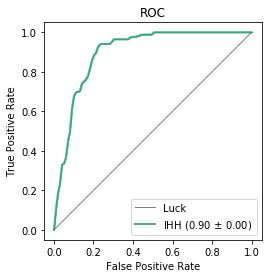

In [139]:
plot_roc(res_apoe2ldlr, classes=['IHH'])

In [140]:
it_ldlr = exp2_ldlr.classify('exposure_type', RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                                 exp2_ldlr.data, exp2_ldlr.sample_metadata['exposure_type'], exp2_ldlr.sample_metadata['mouse_number']))

In [141]:
res_ldlr = next(it_ldlr)

In [142]:
res_ldlr.head()

,Air,IHH,Y_TRUE,SAMPLE,CV
0,0.094,0.906,IHH,10422.17.F.10,0
1,0.076,0.924,IHH,10422.17.F.11,0
2,0.100,0.900,IHH,10422.17.F.12,0
3,0.104,0.896,IHH,10422.17.F.13,0
4,0.260,0.740,IHH,10422.17.F.3,0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd9f15a2b70>,
 0.98778696051423331)

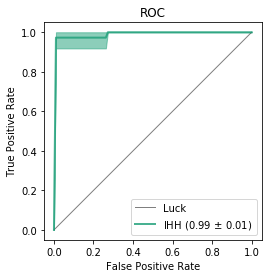

In [143]:
plot_roc(res_ldlr, classes=['IHH'])

In [25]:
clf_ldlr = RandomForestClassifier(500, oob_score=True)
clf_ldlr.fit(exp2_ldlr.data, exp2_ldlr.sample_metadata.exposure_type)
clf_ldlr.oob_score_

0.95882352941176474

In [145]:
res_ldlr2apoe = pd.DataFrame(clf_ldlr.predict_proba(exp2_apoe.data))
res_ldlr2apoe.columns = clf_ldlr.classes_
res_ldlr2apoe['Y_TRUE'] = exp2_apoe.sample_metadata['exposure_type'].values
res_ldlr2apoe['CV'] = 0

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd9f1579cc0>,
 0.93028550916133212)

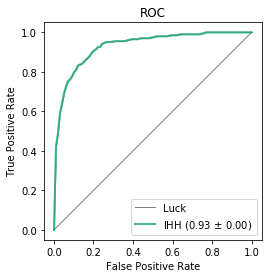

In [146]:
plot_roc(res_ldlr2apoe, classes=['IHH'])

# feature imp

In [62]:
imp = pd.DataFrame({'apoe': clf_apoe.feature_importances_,
                    'ldlr': clf_ldlr.feature_importances_})

In [64]:
imp_rank = imp.rank(ascending=False)

In [63]:
imp.head()

,apoe,ldlr
0,0.000042,0.0
1,0.000041,0.0
2,0.000000,0.0
3,0.000017,0.0
4,0.000000,0.0


In [65]:
imp_rank.head()

,apoe,ldlr
0,617.0,1591.0
1,625.0,1591.0
2,2058.0,1591.0
3,1094.0,1591.0
4,2058.0,1591.0


In [156]:
imp_rank.query('apoe==392')

,apoe,ldlr
0,392.0,342.5
5,392.0,342.5
8,392.0,107.0
11,392.0,76.0
24,392.0,33.0
25,392.0,45.0
26,392.0,52.0
27,392.0,197.0
29,392.0,6.0
35,392.0,342.5


In [157]:
imp.query('apoe==0')

,apoe,ldlr
0,0.0,0.000000
5,0.0,0.000000
8,0.0,0.001801
11,0.0,0.002885
24,0.0,0.007060
25,0.0,0.005388
26,0.0,0.004124
27,0.0,0.000325
29,0.0,0.030039
35,0.0,0.000000


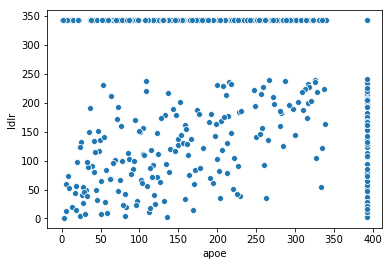

In [159]:
sns.scatterplot(x='apoe', y='ldlr', data=imp_rank)

In [162]:
apoe_imp0 = imp.query('apoe==0 & ldlr!=0')
ldlr_imp0 = imp.query('apoe!=0 & ldlr==0')

In [163]:
len(apoe_imp0)

60

In [164]:
len(ldlr_imp0)

159

In [172]:
imp_rank_no0 = imp_rank.drop(index=apoe_imp0.index.tolist()+ldlr_imp0.index.tolist())
imp_rank_no0.corr()

,apoe,ldlr
apoe,1.00000,0.82284
ldlr,0.82284,1.00000


Text(0,0.5,'ldlr feature importance')

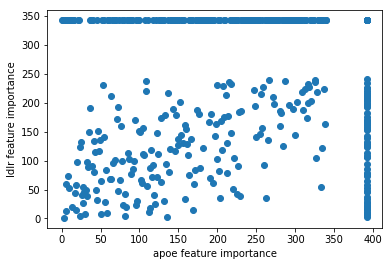

In [160]:
fig, ax = plt.subplots()
ax.scatter(imp_rank.apoe, imp_rank.ldlr)
ax.set_xlabel('apoe feature importance')
ax.set_ylabel('ldlr feature importance')

In [167]:
fig.savefig('microbes-feature-imp-scatter.pdf')

In [174]:
stats.pearsonr(imp_rank_no0.apoe, imp_rank_no0.ldlr)

(0.82284037298756973, 2.1068129297322047e-56)

In [175]:
stats.pearsonr(imp_rank.apoe, imp_rank.ldlr)

(0.19540651212930696, 3.4549386303949459e-05)

In [45]:
exp2.feature_metadata['apoe_imp'] = imp.apoe.values
exp2.feature_metadata['ldlr_imp'] = imp.ldlr.values
exp2.feature_metadata['apoe_imp_rank'] = imp_rank.apoe.values
exp2.feature_metadata['ldlr_imp_rank'] = imp_rank.ldlr.values

2018-07-26 18:50:08 WARNING Do you forget to normalize your data? It is required before running this function


<IPython.core.display.Javascript object>


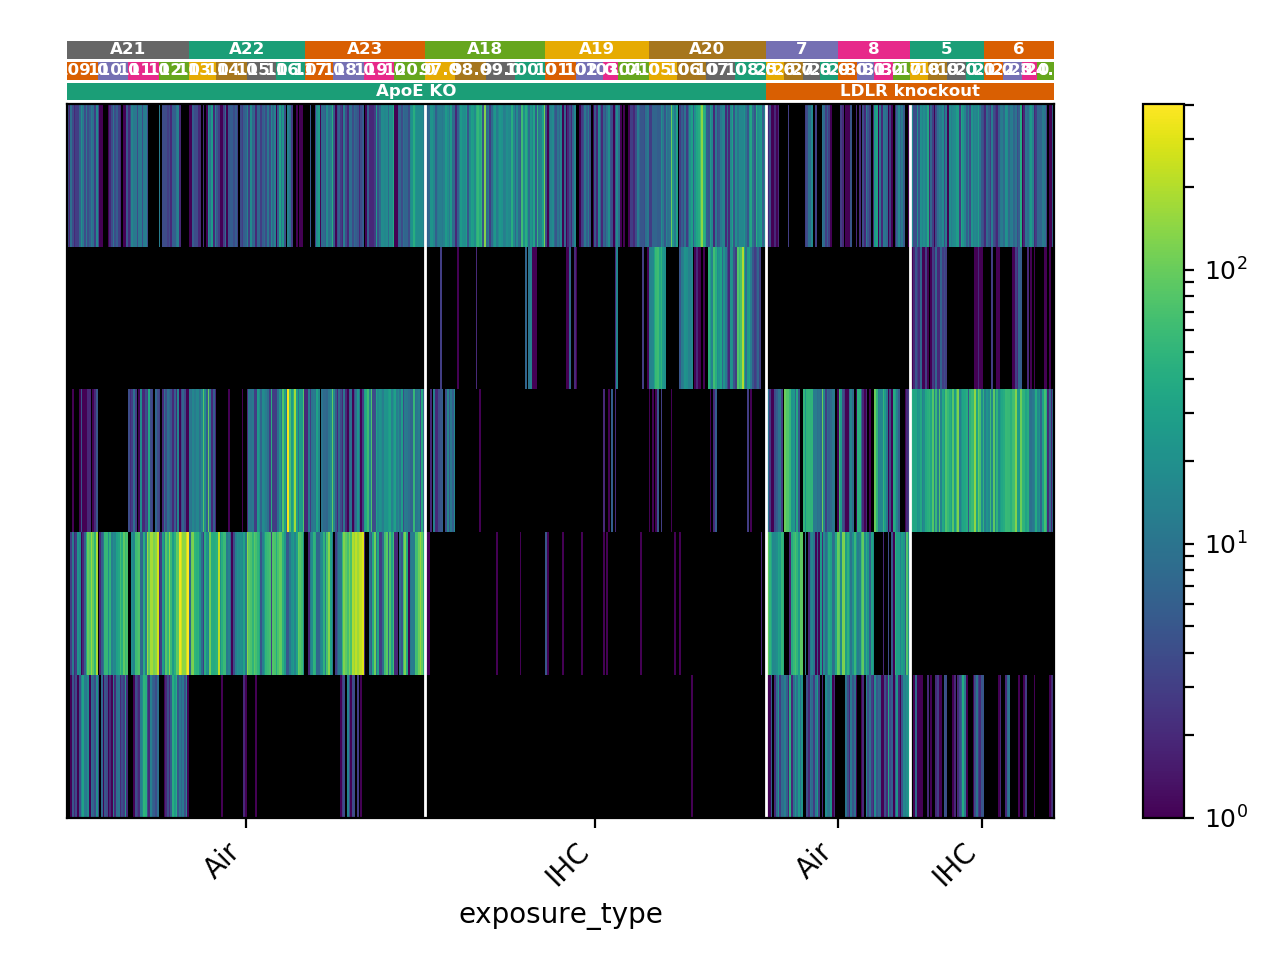

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [50]:
n = 30
exp3 = (exp2.filter_by_metadata('ldlr_imp_rank', lambda x: [i < n for i in x], axis=1)
         .filter_by_metadata('apoe_imp_rank', lambda x: [i < n for i in x], axis=1))
(exp3
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     .cluster_features()
     .plot(sample_field='exposure_type', barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

In [52]:
import pickle
with open('common-imp-microbes.pkl', 'wb') as f:
    pickle.dump(exp3, f)

In [281]:
features = []
for i in exp3.feature_metadata.index:
    df = pd.DataFrame({'abundance': exp3[:, i],
                       'taxonomy': exp3.feature_metadata.loc[i, 'taxonomy'],
                       'genotype': exp3.sample_metadata['genotype'],
                       'age': exp3.sample_metadata['age'],
                       'exposure_type': exp3.sample_metadata['exposure_type']})
    features.append(df)

features = pd.concat(features, axis=0)

features.to_csv('common-imp-microbes.tsv', sep='\t')

2018-07-26 18:19:19 WARNING Do you forget to normalize your data? It is required before running this function


<IPython.core.display.Javascript object>


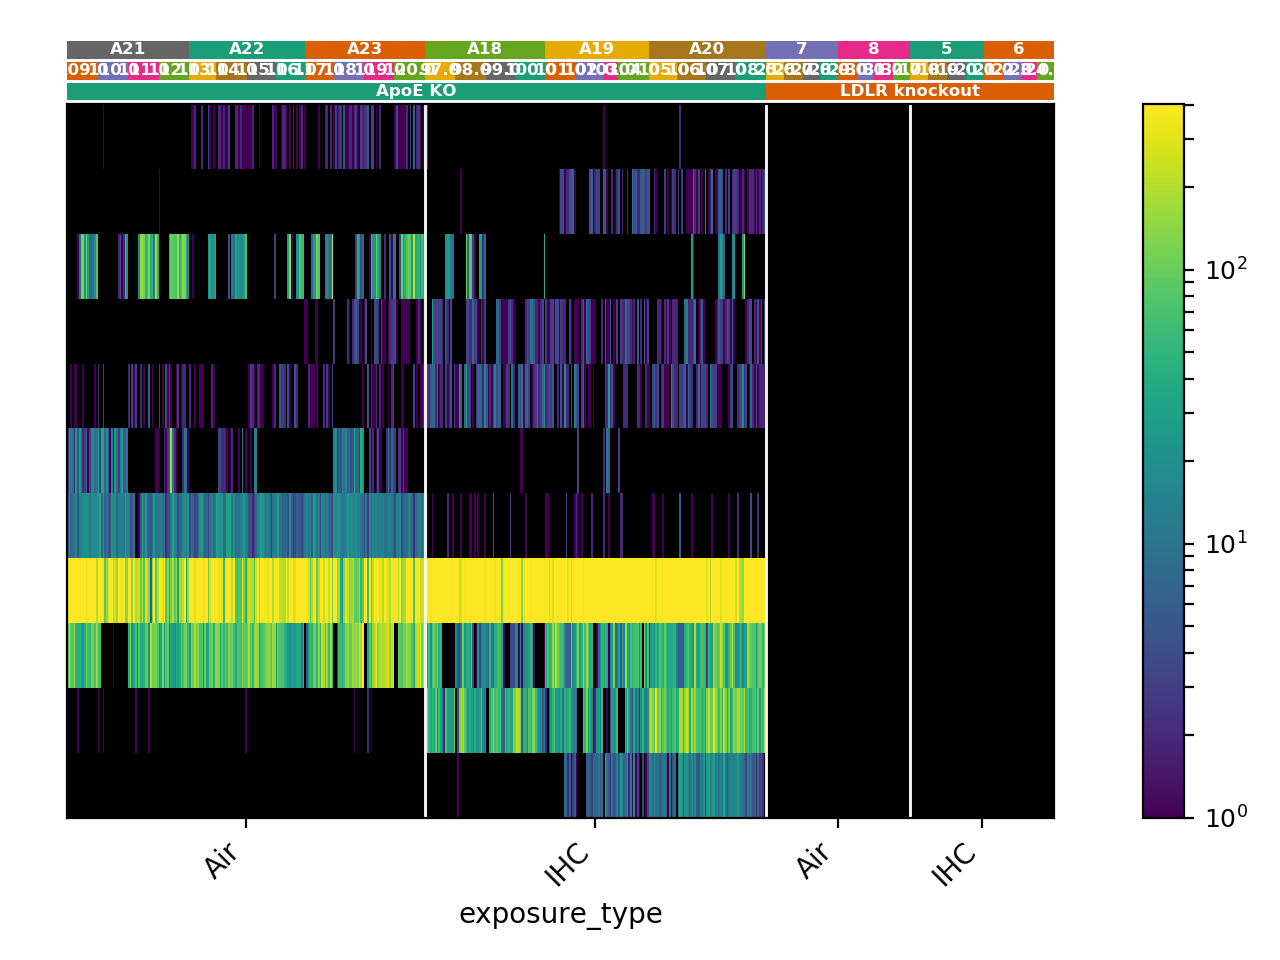

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [47]:
(exp2.filter_by_metadata('ldlr_imp', lambda x: [i==0 for i in x], axis=1)
     .filter_by_metadata('apoe_imp_rank', lambda x: [i < 30 for i in x], axis=1)
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     .cluster_features()
     .plot(sample_field='exposure_type', barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

2018-07-26 18:19:24 WARNING Do you forget to normalize your data? It is required before running this function


<IPython.core.display.Javascript object>


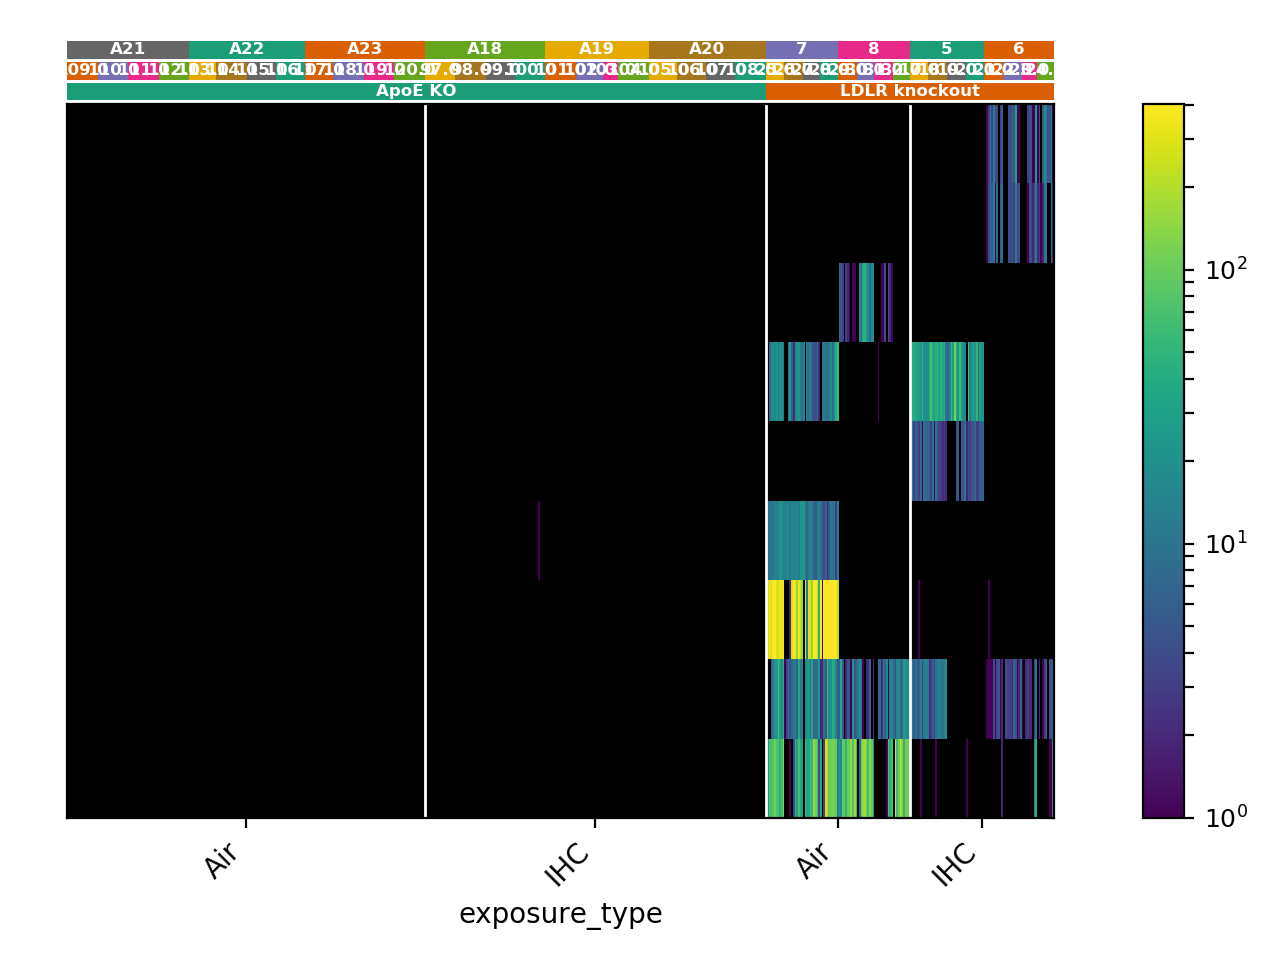

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [48]:
(exp2.filter_by_metadata('apoe_imp', lambda x: [i==0 for i in x], axis=1)
     .filter_by_metadata('ldlr_imp_rank', lambda x: [i < 30 for i in x], axis=1)
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     .cluster_features()
     .plot(sample_field='exposure_type', 
           barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

# diff abundance

In [108]:
exp2_apoe_diff = exp2_apoe.diff_abundance('exposure_type', val1='Air', val2='IHH', alpha=0.01)

In [109]:
exp2_apoe_diff

AmpliconExperiment ("combined_apoe_ldlr_norare_2k_matched.qza") with 460 samples, 127 features

In [113]:
exp2_ldlr_diff = exp2_ldlr.diff_abundance('exposure_type', val1='Air', val2='IHH', alpha=0.01)
exp2_ldlr_diff

AmpliconExperiment ("combined_apoe_ldlr_norare_2k_matched.qza") with 182 samples, 78 features

In [111]:
fids_diff = set(exp2_apoe_diff.feature_metadata.index) & set(exp2_ldlr_diff.feature_metadata.index)

In [31]:
from sklearn.metrics import roc_auc_score

In [80]:
with open('microbes.tsv', 'w') as f:
    f.write('amplicon\tAPOE AUC\tLDLR AUC\ttaxonomy\n')
    for i in exp2.feature_metadata.index:
        taxon = exp2_apoe.feature_metadata.loc[i, 'taxonomy']
        apoe_score = exp2_apoe[:, i]
        apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
        a = roc_auc_score(apoe_true, apoe_score)
        if a < 0.5:
            a = 1 - a

        ldlr_score = exp2_ldlr[:, i]
        ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
        b = roc_auc_score(ldlr_true, ldlr_score)
        if b < 0.5:
            b = 1 - b
            
        f.write('\t'.join([i,'{:.3f}'.format(a), '{:.3f}'.format(b), taxon,]))
        f.write('\n')

Text(0.5,1.08,'APOE KO')

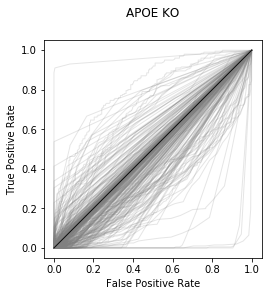

In [47]:
from matplotlib import pyplot as plt
fig_apoe, ax_apoe = plt.subplots()
ax_apoe.set_aspect('equal')

fids_apoe = []
for i in exp2_apoe.feature_metadata.index:
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_apoe.append(i)
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=1, color='gray', alpha=0.2)

ax_apoe.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_apoe.set_xlim(-0.05, 1.05)
ax_apoe.set_ylim(-0.05, 1.05)
ax_apoe.set_xlabel('False Positive Rate')
ax_apoe.set_ylabel('True Positive Rate')
ax_apoe.set_title('APOE KO',  y=1.08)

Text(0.5,1.08,'LDLR KO')

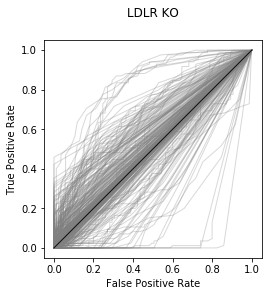

In [48]:
from matplotlib import pyplot as plt
fig_ldlr, ax_ldlr = plt.subplots()
ax_ldlr.set_aspect('equal')
fids_ldlr = []

for i in exp2_ldlr.feature_metadata.index:
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_ldlr.append(i)
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=1, color='gray', alpha=0.3)

ax_ldlr.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_ldlr.set_xlim(-0.05, 1.05)
ax_ldlr.set_ylim(-0.05, 1.05)
ax_ldlr.set_xlabel('False Positive Rate')
ax_ldlr.set_ylabel('True Positive Rate')
ax_ldlr.set_title('LDLR KO',  y=1.08)

In [49]:
fids = list(set(fids_apoe) & set(fids_ldlr))

In [50]:
fids.sort()

In [51]:
print(fids)

['TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGCGCAAGTCTGGAGTGAAATGCCGGGGCCCAACCCCGGAACTGCTTTGGAAACTGTGCAGCTCGAGTGCAGGAGAGGTAAGCGGAATTCCTAG', 'TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG']


In [122]:
features = []
for n, i in enumerate(fids_diff, 1):
    df = pd.DataFrame({'abundance': exp2[:, i],
                       'taxonomy': 'microbe %d:' % n + exp2.feature_metadata.loc[i, 'taxonomy'],
                       'feature': i,
                       'genotype': exp2.sample_metadata['genotype'],
                       'age': exp2.sample_metadata['age'],
                       'exposure_type': exp2.sample_metadata['exposure_type']})
    #df['taxonomy'] = 
    features.append(df)

features = pd.concat(features, axis=0)

features.to_csv('common-imp-microbes2.tsv', sep='\t')

In [53]:
for n, (i, c) in enumerate(zip(fids, plt.cm.tab10.colors), 1):
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=c, label='microbe %d (%.2f)' % (n, a))
ax_apoe.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_apoe.tight_layout()

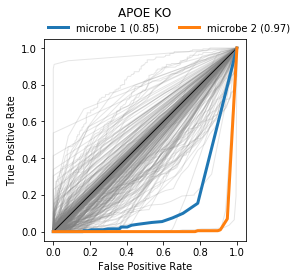

In [54]:
fig_apoe

In [55]:
for n, (i, c) in enumerate(zip(fids, plt.cm.tab10.colors), 1):
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=c, label='microbe %d (%.2f)' % (n, a))
ax_ldlr.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False,  loc="lower left")
fig_ldlr.tight_layout()

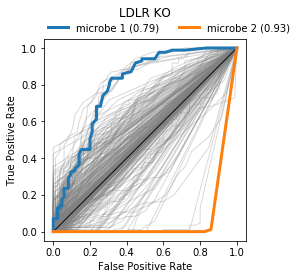

In [56]:
fig_ldlr

In [59]:
with PdfPages('roc-microbes.pdf') as pdf:
    pdf.savefig(fig_apoe)
    pdf.savefig(fig_ldlr)

## r plot


In [380]:
!open trend-microbes.pdf